<a href="https://colab.research.google.com/github/thangnc423/MMASH-dataset-processing-and-models/blob/main/MMASH_data_processing.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import os

In [ ]:
ls drive/MyDrive/CS256/*

'drive/MyDrive/CS256/CS256 First Exam Review.gdoc'
'drive/MyDrive/CS256/CS256 Paper Presentation.gslides'
 drive/MyDrive/CS256/X_selected2.csv
 drive/MyDrive/CS256/X_selected.csv
 drive/MyDrive/CS256/y_df2.csv
 drive/MyDrive/CS256/y_df.csv

drive/MyDrive/CS256/DataPaper:
user_1/   user_12/  user_15/  user_18/  user_20/  user_3/  user_6/  user_9/
user_10/  user_13/  user_16/  user_19/  user_21/  user_4/  user_7/
user_11/  user_14/  user_17/  user_2/   user_22/  user_5/  user_8/


In [ ]:
path = "drive/MyDrive/CS256/DataPaper"
users = os.listdir(path)[:-1]

In [ ]:
def create_dataframe(fileName):
    df_concat = pd.DataFrame()
    for user in users:
        try:
            df = pd.read_csv(f"drive/MyDrive/CS256/DataPaper/{user}/{fileName}.csv")
            df["user"] = user
            df_concat = pd.concat([df_concat,df])
        except:
            print(f"{fileName}.csv not found for user {user}")
            pass

    # delete the unnamed column
    del df_concat["Unnamed: 0"]
    df_concat = df_concat.set_index("user")

    return(df_concat)

In [ ]:
df_activity = create_dataframe('Activity')

In [ ]:
activity_mapping = {
    1: "Sleeping",
    2: "Laying down",
    3: "Sitting",
    4: "Light movement",
    5: "Medium movement",
    6: "Heavy movement",
    7: "Eating",
    8: "Small screen usage",
    9: "Large screen usage",
    10: "Caffeinated drink consumption",
    11: "Smoking",
    12: "Alcohol consumption"
}

df_activity['Activity'] = df_activity['Activity'].replace(activity_mapping) # maping activity
df_activity = df_activity[df_activity['Activity'] != 0] # ignore activity 0 (Other)

In [ ]:
df_question = create_dataframe('questionnaire')

In [ ]:
df_actigraph = create_dataframe('Actigraph')

# **Data Preprocessing**

## **Handling Missing Values**

In [ ]:
print(df_activity.isna().sum())

Activity    0
Start       0
End         0
Day         0
dtype: int64


For Activity, there are no missing values so I don't have to handle NaNs.

In [ ]:
print(df_question.isna().sum())

MEQ              0
STAI1            0
STAI2            0
Pittsburgh       0
Daily_stress     0
BISBAS_bis       0
BISBAS_reward    0
BISBAS_drive     0
BISBAS_fun       0
panas_pos_10     0
panas_pos_14     1
panas_pos_18     0
panas_pos_22     0
panas_pos_9+1    0
panas_neg_10     0
panas_neg_14     1
panas_neg_18     0
panas_neg_22     0
panas_neg_9+1    0
dtype: int64


For Questionnaire, there are two NaN values for user panas_pos_14 and panas_neg_14. As such, I will interpolate using panas_pos_10 and panas_neg_10, and panas_pos_18 and panas_neg_18, respectively.

In [ ]:
df_question['panas_pos_14'] = df_question[['panas_pos_10', 'panas_pos_14', 'panas_pos_18']].interpolate(axis=1)['panas_pos_14']
df_question['panas_neg_14'] = df_question[['panas_neg_10', 'panas_neg_14', 'panas_neg_18']].interpolate(axis=1)['panas_neg_14']
print(df_question.isna().sum())

MEQ              0
STAI1            0
STAI2            0
Pittsburgh       0
Daily_stress     0
BISBAS_bis       0
BISBAS_reward    0
BISBAS_drive     0
BISBAS_fun       0
panas_pos_10     0
panas_pos_14     0
panas_pos_18     0
panas_pos_22     0
panas_pos_9+1    0
panas_neg_10     0
panas_neg_14     0
panas_neg_18     0
panas_neg_22     0
panas_neg_9+1    0
dtype: int64


In [ ]:
print(df_actigraph.isna().sum())

Axis1                    0
Axis2                    0
Axis3                    0
Steps                    0
HR                       0
Inclinometer Off         0
Inclinometer Standing    0
Inclinometer Sitting     0
Inclinometer Lying       0
Vector Magnitude         0
day                      0
time                     0
dtype: int64


For Actigraph, there are no missing values so I don't have to handle NaNs.

## **Noise Reduction**
Since I am just working with one sensor axis (accelerometer), noise reduction with the Butterworth filter would be ideal over Kalman filter. Inclinometer is stored as binary, so it's unfit for smoothing.

In [ ]:
temp = df_actigraph.copy()

In [ ]:
from scipy.signal import butter, filtfilt

def butter_lowpass_filter(data, cutoff, fs, order=4):
    nyquist = 0.5 * fs
    normal_cutoff = cutoff / nyquist
    b, a = butter(order, normal_cutoff, btype='low', analog=False)
    return filtfilt(b, a, data)

### **Finding a good cutoff for Butterworth filtering**

Text(0.5, 1.0, 'Effect of cutoff frequency on Axis1')

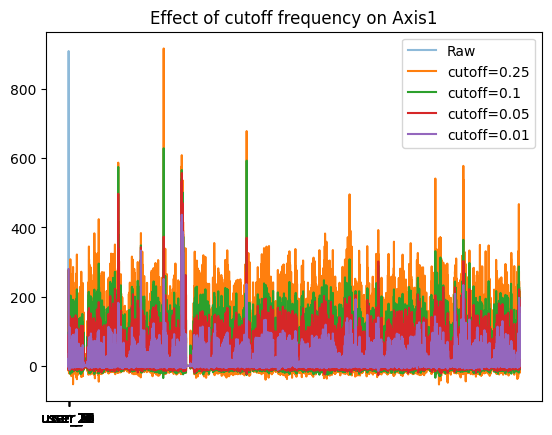

In [ ]:
plt.plot(temp['Axis1'], alpha=0.5, label='Raw')
for cutoff in [0.25, 0.1, 0.05, 0.01]:
    filtered = butter_lowpass_filter(temp['Axis1'], cutoff=cutoff, fs=1)
    plt.plot(filtered, label=f'cutoff={cutoff}')
plt.legend()
plt.title("Effect of cutoff frequency on Axis1")

In [ ]:
old = df_actigraph.copy()

In [ ]:
fs = 1        # sampling frequency (data is stored by second so this is 1)
cutoff = 0.05  # a good middleground

for axis in ['Axis1', 'Axis2', 'Axis3']:
    df_actigraph[axis] = butter_lowpass_filter(df_actigraph[axis], cutoff=cutoff, fs=fs)

In [ ]:
df_actigraph.compare(old)

Axis1             Axis2              Axis3       
               self  other       self  other        self  other
user                                                           
user_20  275.927788  275.0  86.845909   86.0   67.184286   67.0
user_20  229.532099   93.0  79.770857  112.0   63.383195   45.0
user_20  184.782958   69.0  72.813195   39.0   59.573118   61.0
user_20  143.170212   66.0  66.087401   86.0   55.736536  140.0
user_20  105.899256   50.0  59.671134   44.0   51.856979   38.0
...             ...    ...        ...    ...         ...    ...
user_1    50.316893   31.0  25.019260    0.0   84.390346   31.0
user_1    56.977097   34.0  23.928573    0.0  115.578182   17.0
user_1    64.872523    7.0  23.526186    4.0  151.656047    3.0
user_1    73.655304   12.0  23.733573   50.0  191.265725   13.0
user_1    82.898756   84.0  24.421217   27.0  232.740684  237.0

[1404062 rows x 6 columns]

## **Normalization**
Z-score normalization will be used since there are no explicit min and max value thresholds for the accelerometer measurements. There's no need to normalize for Activity and Questionnaire.

In [ ]:
df_actigraph

,Axis1,Axis2,Axis3,Steps,HR,Inclinometer Off,Inclinometer Standing,Inclinometer Sitting,Inclinometer Lying,Vector Magnitude,day,time
user,,,,,,,,,,,,
user_20,275.927788,86.845909,67.184286,1,72.0,0,1,0,0,295.82,1,09:27:23
user_20,229.532099,79.770857,63.383195,1,69.0,0,1,0,0,152.37,1,09:27:24
user_20,184.782958,72.813195,59.573118,0,68.0,0,1,0,0,100.01,1,09:27:25
user_20,143.170212,66.087401,55.736536,1,68.0,0,1,0,0,177.06,1,09:27:26
user_20,105.899256,59.671134,51.856979,0,69.0,0,1,0,0,76.68,1,09:27:27
...,...,...,...,...,...,...,...,...,...,...,...,...
user_1,50.316893,25.019260,84.390346,1,119.0,0,1,0,0,43.84,2,09:45:25
user_1,56.977097,23.928573,115.578182,0,121.0,0,1,0,0,38.01,2,09:45:26
user_1,64.872523,23.526186,151.656047,0,123.0,0,1,0,0,8.60,2,09:45:27


In [ ]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()

df_actigraph[['Axis1', 'Axis2', 'Axis3']] = scaler.fit_transform(df_actigraph[['Axis1', 'Axis2', 'Axis3']])

In [ ]:
df_actigraph

,Axis1,Axis2,Axis3,Steps,HR,Inclinometer Off,Inclinometer Standing,Inclinometer Sitting,Inclinometer Lying,Vector Magnitude,day,time
user,,,,,,,,,,,,
user_20,9.156569,2.185914,1.628698,1,72.0,0,1,0,0,295.82,1,09:27:23
user_20,7.520527,1.966126,1.500318,1,69.0,0,1,0,0,152.37,1,09:27:24
user_20,5.942547,1.749984,1.371634,0,68.0,0,1,0,0,100.01,1,09:27:25
user_20,4.475165,1.541046,1.242055,1,68.0,0,1,0,0,177.06,1,09:27:26
user_20,3.160886,1.341723,1.111024,0,69.0,0,1,0,0,76.68,1,09:27:27
...,...,...,...,...,...,...,...,...,...,...,...,...
user_1,1.200896,0.265253,2.209826,1,119.0,0,1,0,0,43.84,2,09:45:25
user_1,1.435754,0.231371,3.263184,0,121.0,0,1,0,0,38.01,2,09:45:26
user_1,1.714169,0.218871,4.481700,0,123.0,0,1,0,0,8.60,2,09:45:27


## **Data Segmentation**


In [ ]:
# Function to segment the data (with or without overlap)
def segment_data(df, window_size=5, overlap_size=2):
    segments = []  # List to store the segments
    window_step = window_size - overlap_size  # Step size for overlapping windows

    # Iterate through all users
    for user in df.index.unique():
        df_user = df[df.index == user]  # Get data for current user

        # Loop through the data with overlapping windows
        for start_time in range(0, len(df_user) - window_size, window_step):
            window = df_user.iloc[start_time:start_time + window_size]
            segments.append(window)

    return segments

segments = segment_data(df_actigraph, window_size=5, overlap_size=2)

# **Feature Engineering**


## **Time-domain Features**

In [ ]:
from scipy import stats

# Compute time-domain features
def compute_time_domain_features(df_segment):
    vm = df_segment['Vector Magnitude'].values

    # Compute skewness and kurtosis
    skewness = stats.skew(vm, bias=False)
    kurtosis = stats.kurtosis(vm, bias=False)

    # If variance is zero (constant signal), force skewness and kurtosis to 0
    if np.std(vm) == 0:
        skewness = 0.0
        kurtosis = 0.0

    features = {
        'mean': np.mean(vm),
        'std': np.std(vm),
        'energy': np.sum(vm**2),
        'peak_to_peak': np.ptp(vm),
        'skewness': skewness,
        'kurtosis': kurtosis
    }
    return features


## **Frequency-domain Features**

In [ ]:
# Compute frequency-domain features (e.g., dominant frequency and total power)
def compute_frequency_domain_features(df_segment):
    # If the segment is too short
    if len(df_segment) < 2:
        return {'dominant_freq': 0, 'total_power': 0}  # Return default values for frequency features

    # Apply Fourier Transform to the segment
    signal = df_segment['Vector Magnitude'].values
    freqs = np.fft.fftfreq(len(signal), d=1)  # Assuming the time step is 1 second
    fft_values = np.fft.fft(signal)

    # Get the magnitude of the FFT values (complex numbers)
    magnitude = np.abs(fft_values)

    # Compute the dominant frequency and spectral power
    dominant_freq = freqs[np.argmax(magnitude[1:])]  # Ignore the zero frequency (DC component)
    total_power = np.sum(magnitude**2)

    return {'dominant_freq': dominant_freq, 'total_power': total_power}

## **Feature Selection**
First, I split the data into X and y. Then I use feature importance from Random Forest Classifier to pick out the top 6 most important features.

In [ ]:
# non-user-separated
def assign_activity_labels(segments, df_activity):
    y = []
    for segment in segments:
        segment_start_time = segment.iloc[0]['time']
        segment_end_time = segment.iloc[-1]['time']

        activity = df_activity[(df_activity['Start'] <= segment_end_time) &
                               (df_activity['End'] >= segment_start_time)]
        if not activity.empty:
            y.append(activity['Activity'].values[0])
        else:
            y.append('Unknown')  # Handle missing labels
    return y

# user-separated
# def assign_activity_labels(segments, df_activity):
#     y = []
#     for segment in segments:
#         # Get the user from the segment's index
#         user_id = segment.index[0]  # user is index

#         # Get start and end time of the segment
#         segment_start_time = segment.iloc[0]['time']
#         segment_end_time = segment.iloc[-1]['time']

#         # Filter the df_activity for the correct user by matching the index
#         user_activity = df_activity.loc[user_id]

#         # Now check for the activity within the segment's time range
#         activity = user_activity[(user_activity['Start'] <= segment_end_time) &
#                                  (user_activity['End'] >= segment_start_time)]

#         if not activity.empty:
#             y.append(activity['Activity'].values[0])
#         else:
#             y.append('Unknown')  # Handle missing labels
#     return y

y = assign_activity_labels(segments, df_activity)
X = [ {**compute_time_domain_features(segment), **compute_frequency_domain_features(segment)} for segment in segments]

X_df = pd.DataFrame(X)
y_df = pd.DataFrame(y, columns=['Activity'])

print(X_df.shape, y_df.shape)

(467991, 8) (467991, 1)


In [ ]:
print(y_df['Activity'].value_counts(normalize=True))

Activity
Unknown                          0.484905
Sitting                          0.149189
Laying down                      0.138077
Eating                           0.086623
Heavy movement                   0.060723
Small screen usage               0.043548
Medium movement                  0.015876
Sleeping                         0.010237
Alcohol consumption              0.004101
Large screen usage               0.003192
Light movement                   0.001605
Caffeinated drink consumption    0.001571
Smoking                          0.000353
Name: proportion, dtype: float64


In [ ]:
# Filter out 'Unknown' activity rows in y_df
mask = y_df != 'Unknown'

# Apply the mask to y_df and masked indices to X_df
y_df_filtered = y_df[mask]
X_df_filtered = X_df.loc[y_df_filtered.index]

# Check the new distribution of activities
y_df_filtered = y_df_filtered.dropna()
X_df_filtered = X_df_filtered.loc[y_df_filtered.index].dropna()

In [ ]:
# from sklearn.ensemble import RandomForestClassifier

# # Trains Random Forest on full dataset
# rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
# rf_model.fit(X_df, y_df.values.ravel())

# # Gets feature importances
# importances = rf_model.feature_importances_

# # Creates a DataFrame to store feature importance scores
# feature_importance_df = pd.DataFrame({
#     'Feature': X_df.columns,
#     'Importance': importances
# })

# # Sorts features by importance
# feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

# # Selects top N important features
# top_n = 5
# selected_features = feature_importance_df.head(top_n)['Feature'].values

# X_selected = X_df[selected_features]

# print("Selected Features:", selected_features)

In [ ]:
from sklearn.ensemble import RandomForestClassifier

# Trains Random Forest on full dataset
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_df_filtered, y_df_filtered.values.ravel())

# Gets feature importances
importances = rf_model.feature_importances_

# Creates a DataFrame to store feature importance scores
feature_importance_df = pd.DataFrame({
    'Feature': X_df_filtered.columns,
    'Importance': importances
})

# Sorts features by importance
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

# Selects top N important features
top_n = 6
selected_features = feature_importance_df.head(top_n)['Feature'].values

X_selected = X_df_filtered[selected_features]

print("Selected Features:", selected_features)

Selected Features: ['mean' 'std' 'peak_to_peak' 'energy' 'total_power' 'skewness']


Exporting the Dataframe because a single notebook can't handle all of these models.

In [ ]:
# X_selected.to_csv('drive/MyDrive/CS256/X_selected.csv', index=False)
# y_df.to_csv('drive/MyDrive/CS256/y_df.csv', index=False)

In [ ]:
X_selected.to_csv('drive/MyDrive/CS256/X_selected2.csv', index=False)
y_df_filtered.to_csv('drive/MyDrive/CS256/y_df2.csv', index=False)

In [ ]:
X_df_filtered.to_csv('drive/MyDrive/CS256/X_df_filtered.csv', index=False)
y_df_filtered.to_csv('drive/MyDrive/CS256/y_df_filtered.csv', index=False)